<div style="text-align:center">
    <h1>Supernova plot developement</h1>
</div>

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [2]:
from importlib import reload
import sys
sys.path.append("../src")
import plotting

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [7]:
import h5py as h5
with h5.File("/mnt/home/twagg/ceph/pops/supernovae/TESTING.h5", "a") as f:
    f.create_group("sampling_params")

In [17]:
import h5py as h5
with h5.File("/mnt/home/twagg/ceph/pops/supernovae/TESTING.h5", "a") as f:
    f["initial_galaxy"].attrs["params"] = f["initial_galaxy"].attrs["params"].replace("Galaxy", "StarFormationHistory")
    # f["initial_galaxy"].attrs["class_name"] = "StarFormationHistory"

In [18]:
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/supernovae/TESTING")

In [21]:
f = np.load(f"/mnt/home/twagg/ceph/pops/supernovae/sn_positions-TESTING.npz")
p.primary_sn_distances, p.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

In [24]:
plotting.set_sn_subpop_masks(p);

85 1146 757 1431


0.024875621890547442
0.3353819139596137
0.2215393620134623
0.4182031021363767


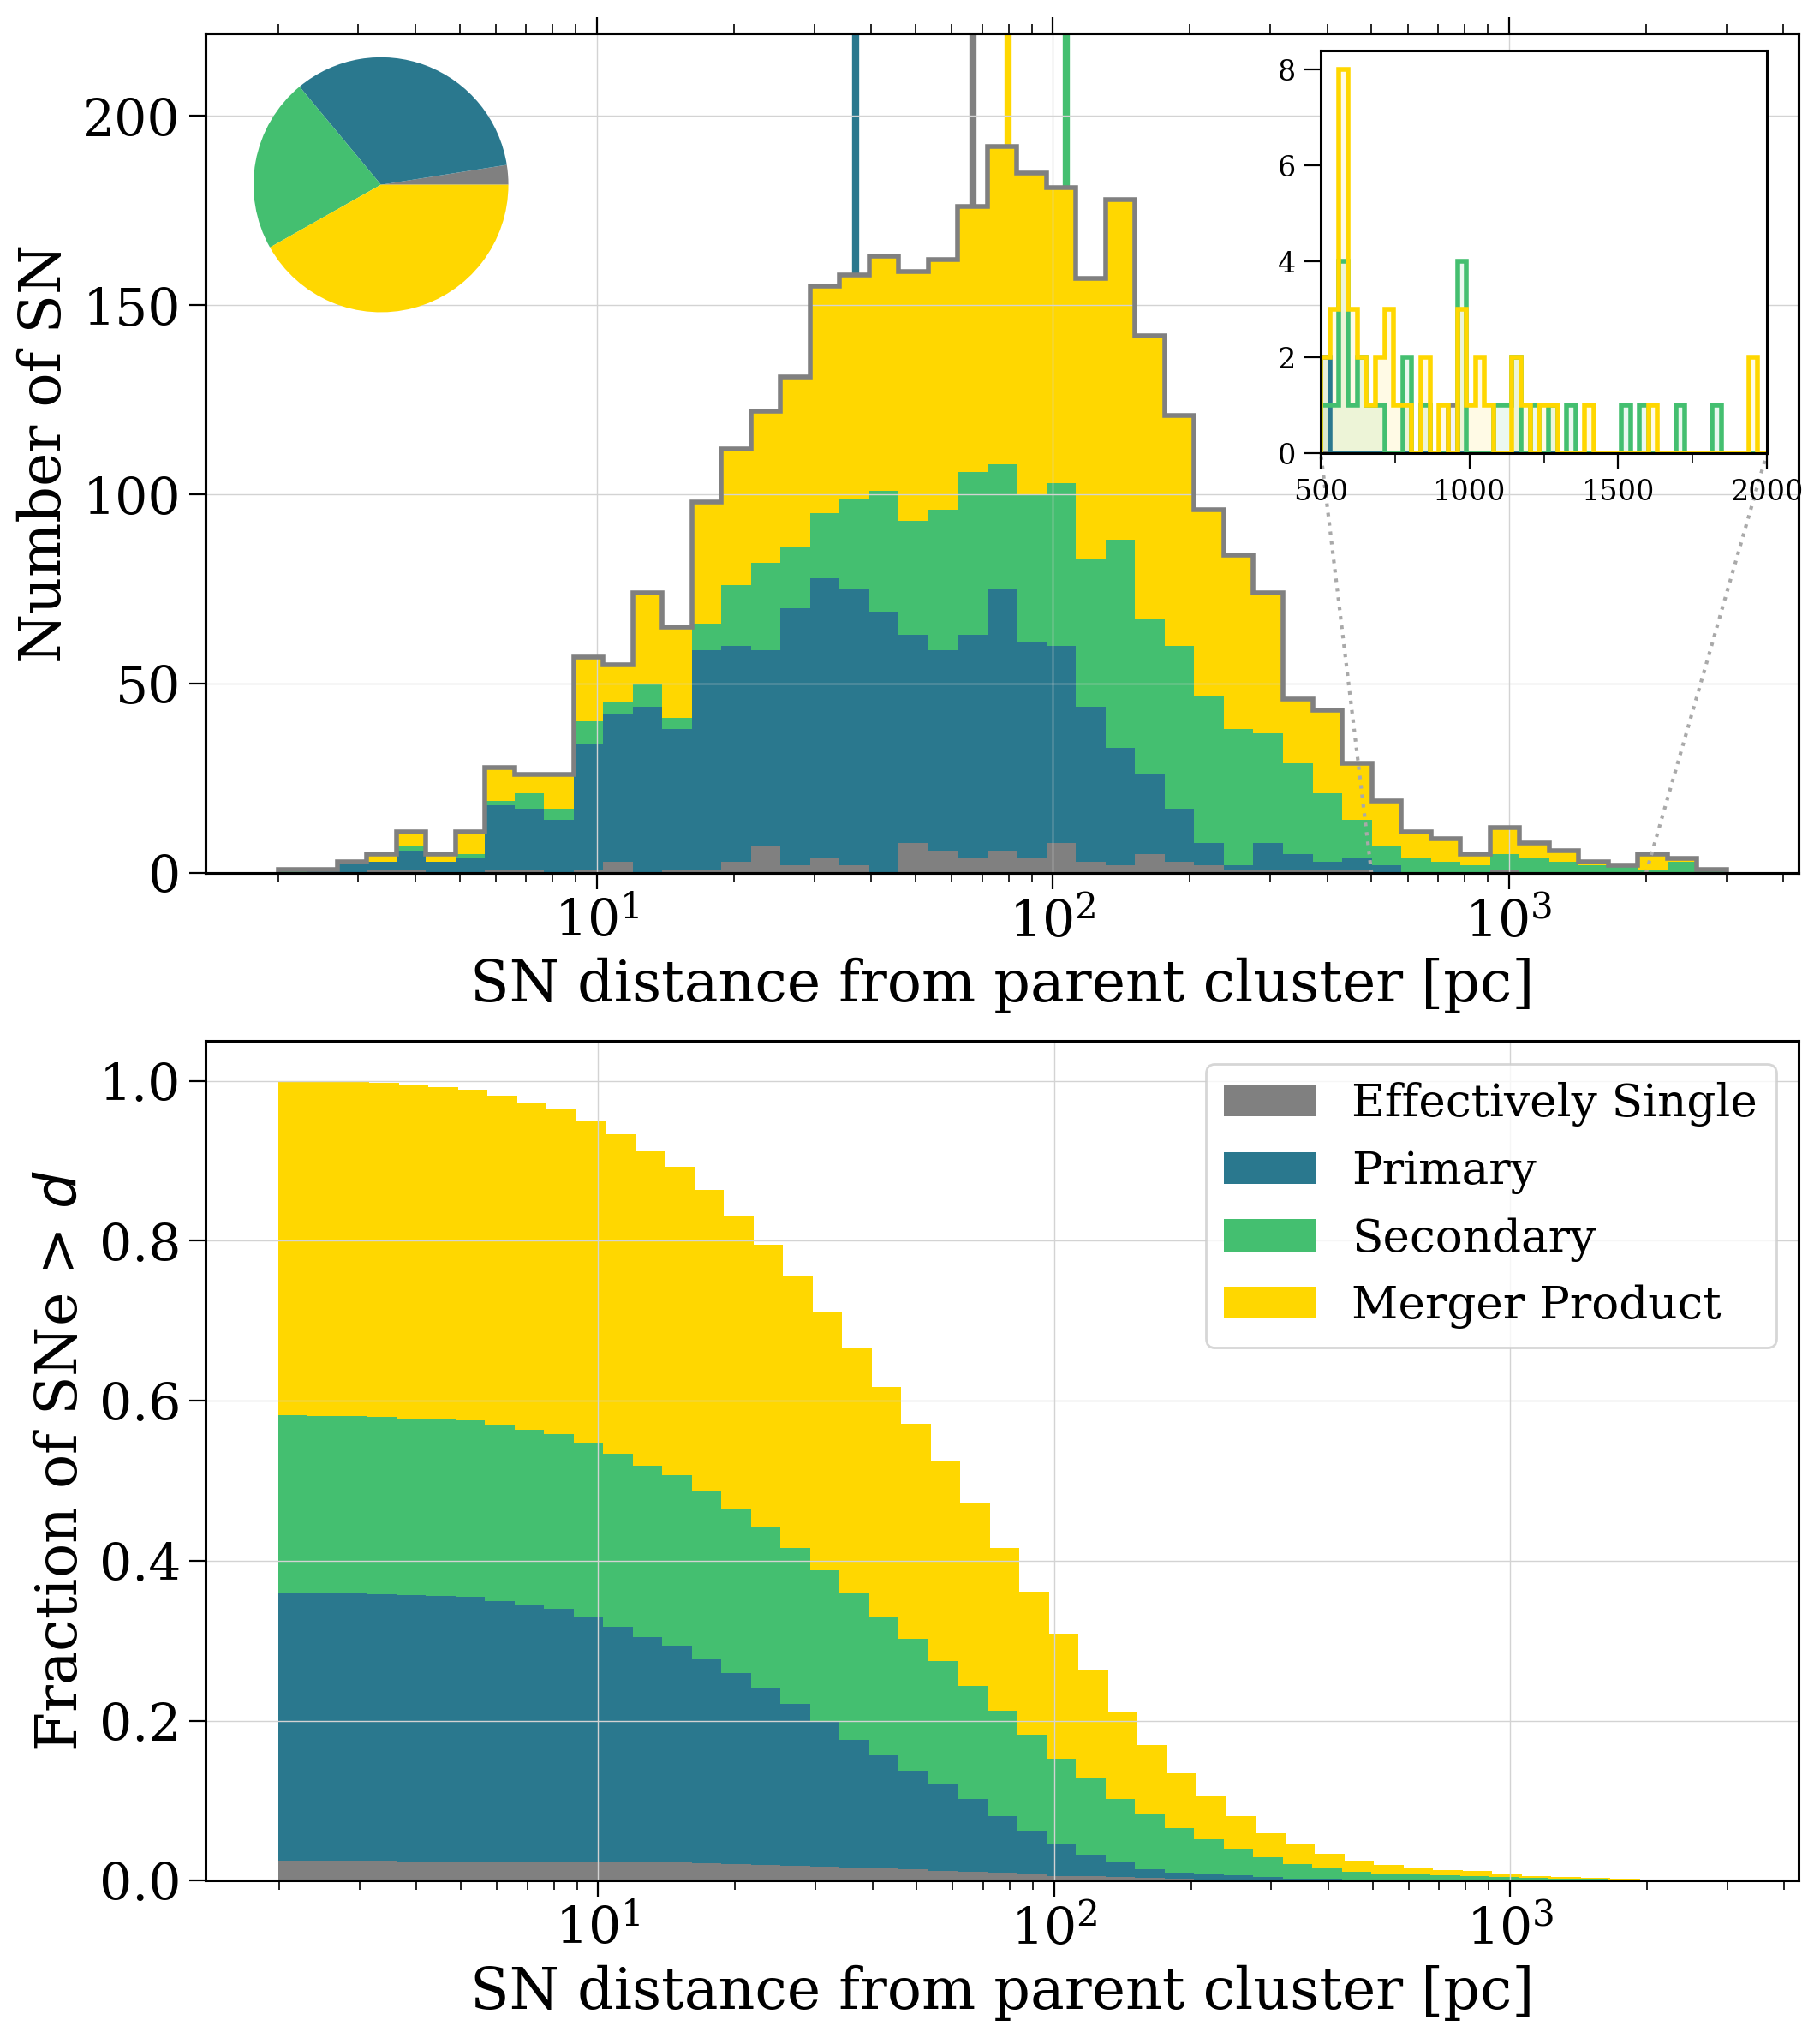

0.03004029970864721
0.25317328683724405
0.21902086427627465
0.4977655491778341


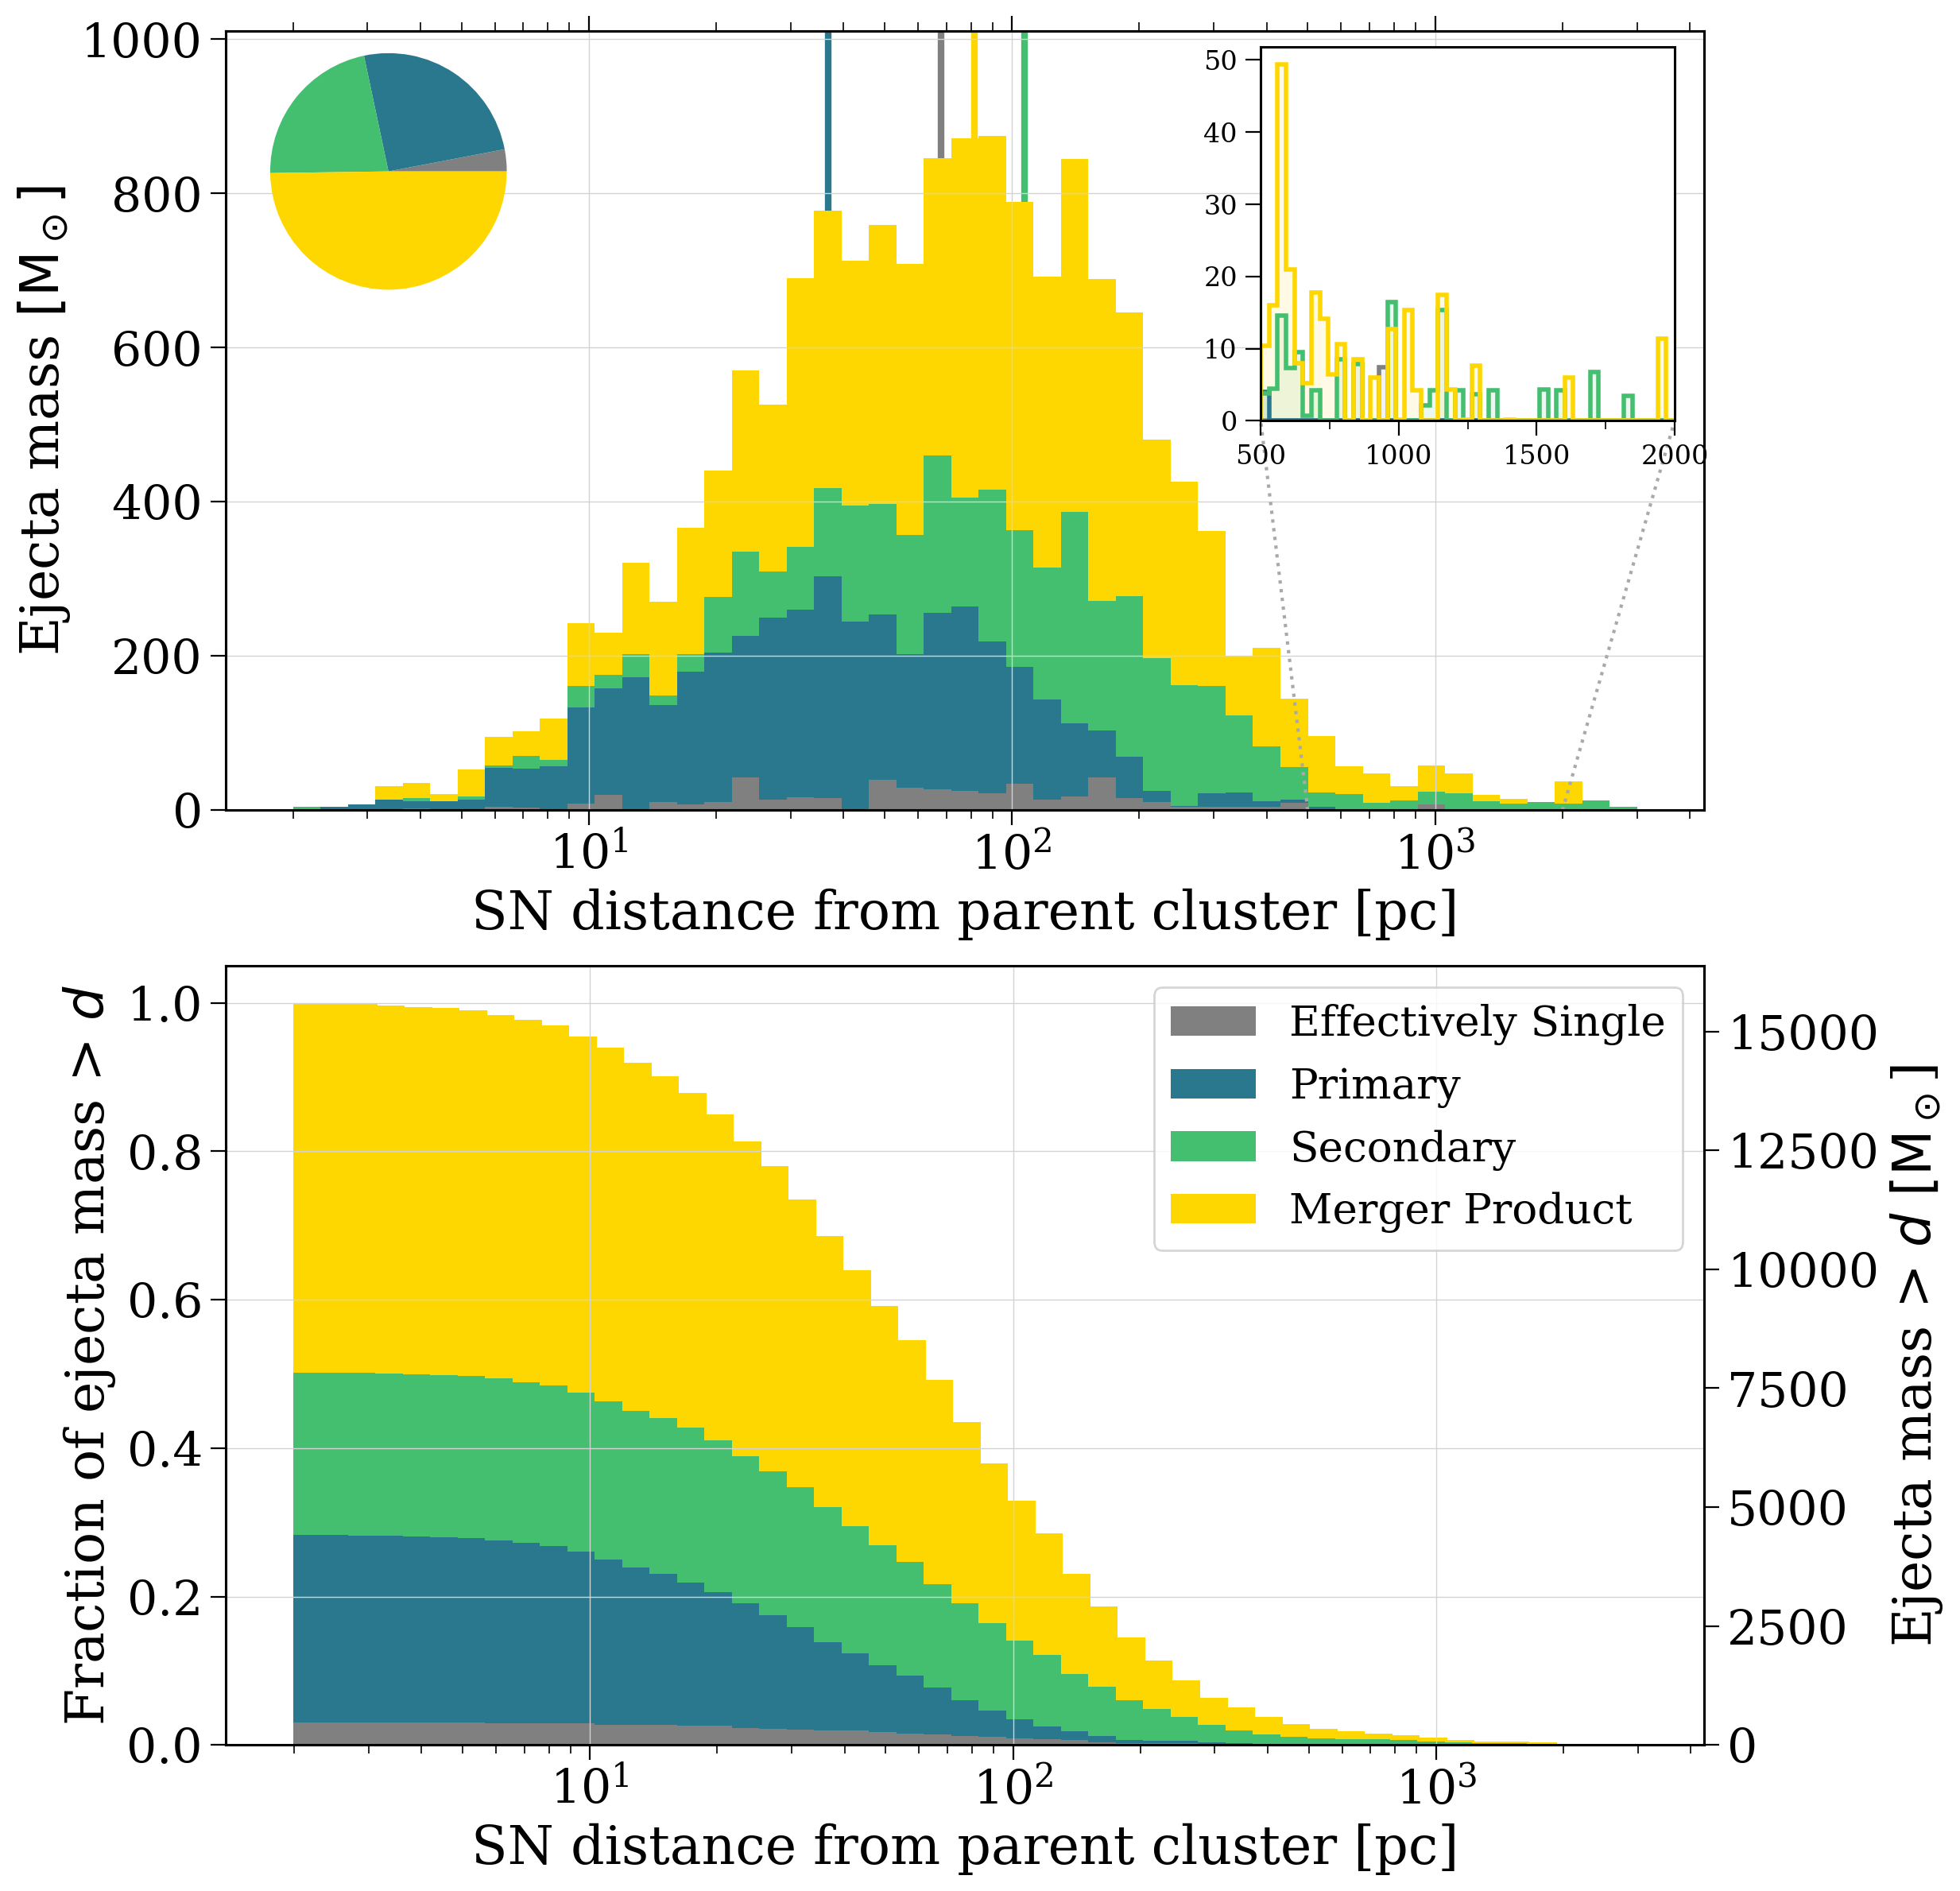

0.02488290398126491
0.3351873536299764
0.2216042154566752
0.4183255269320835


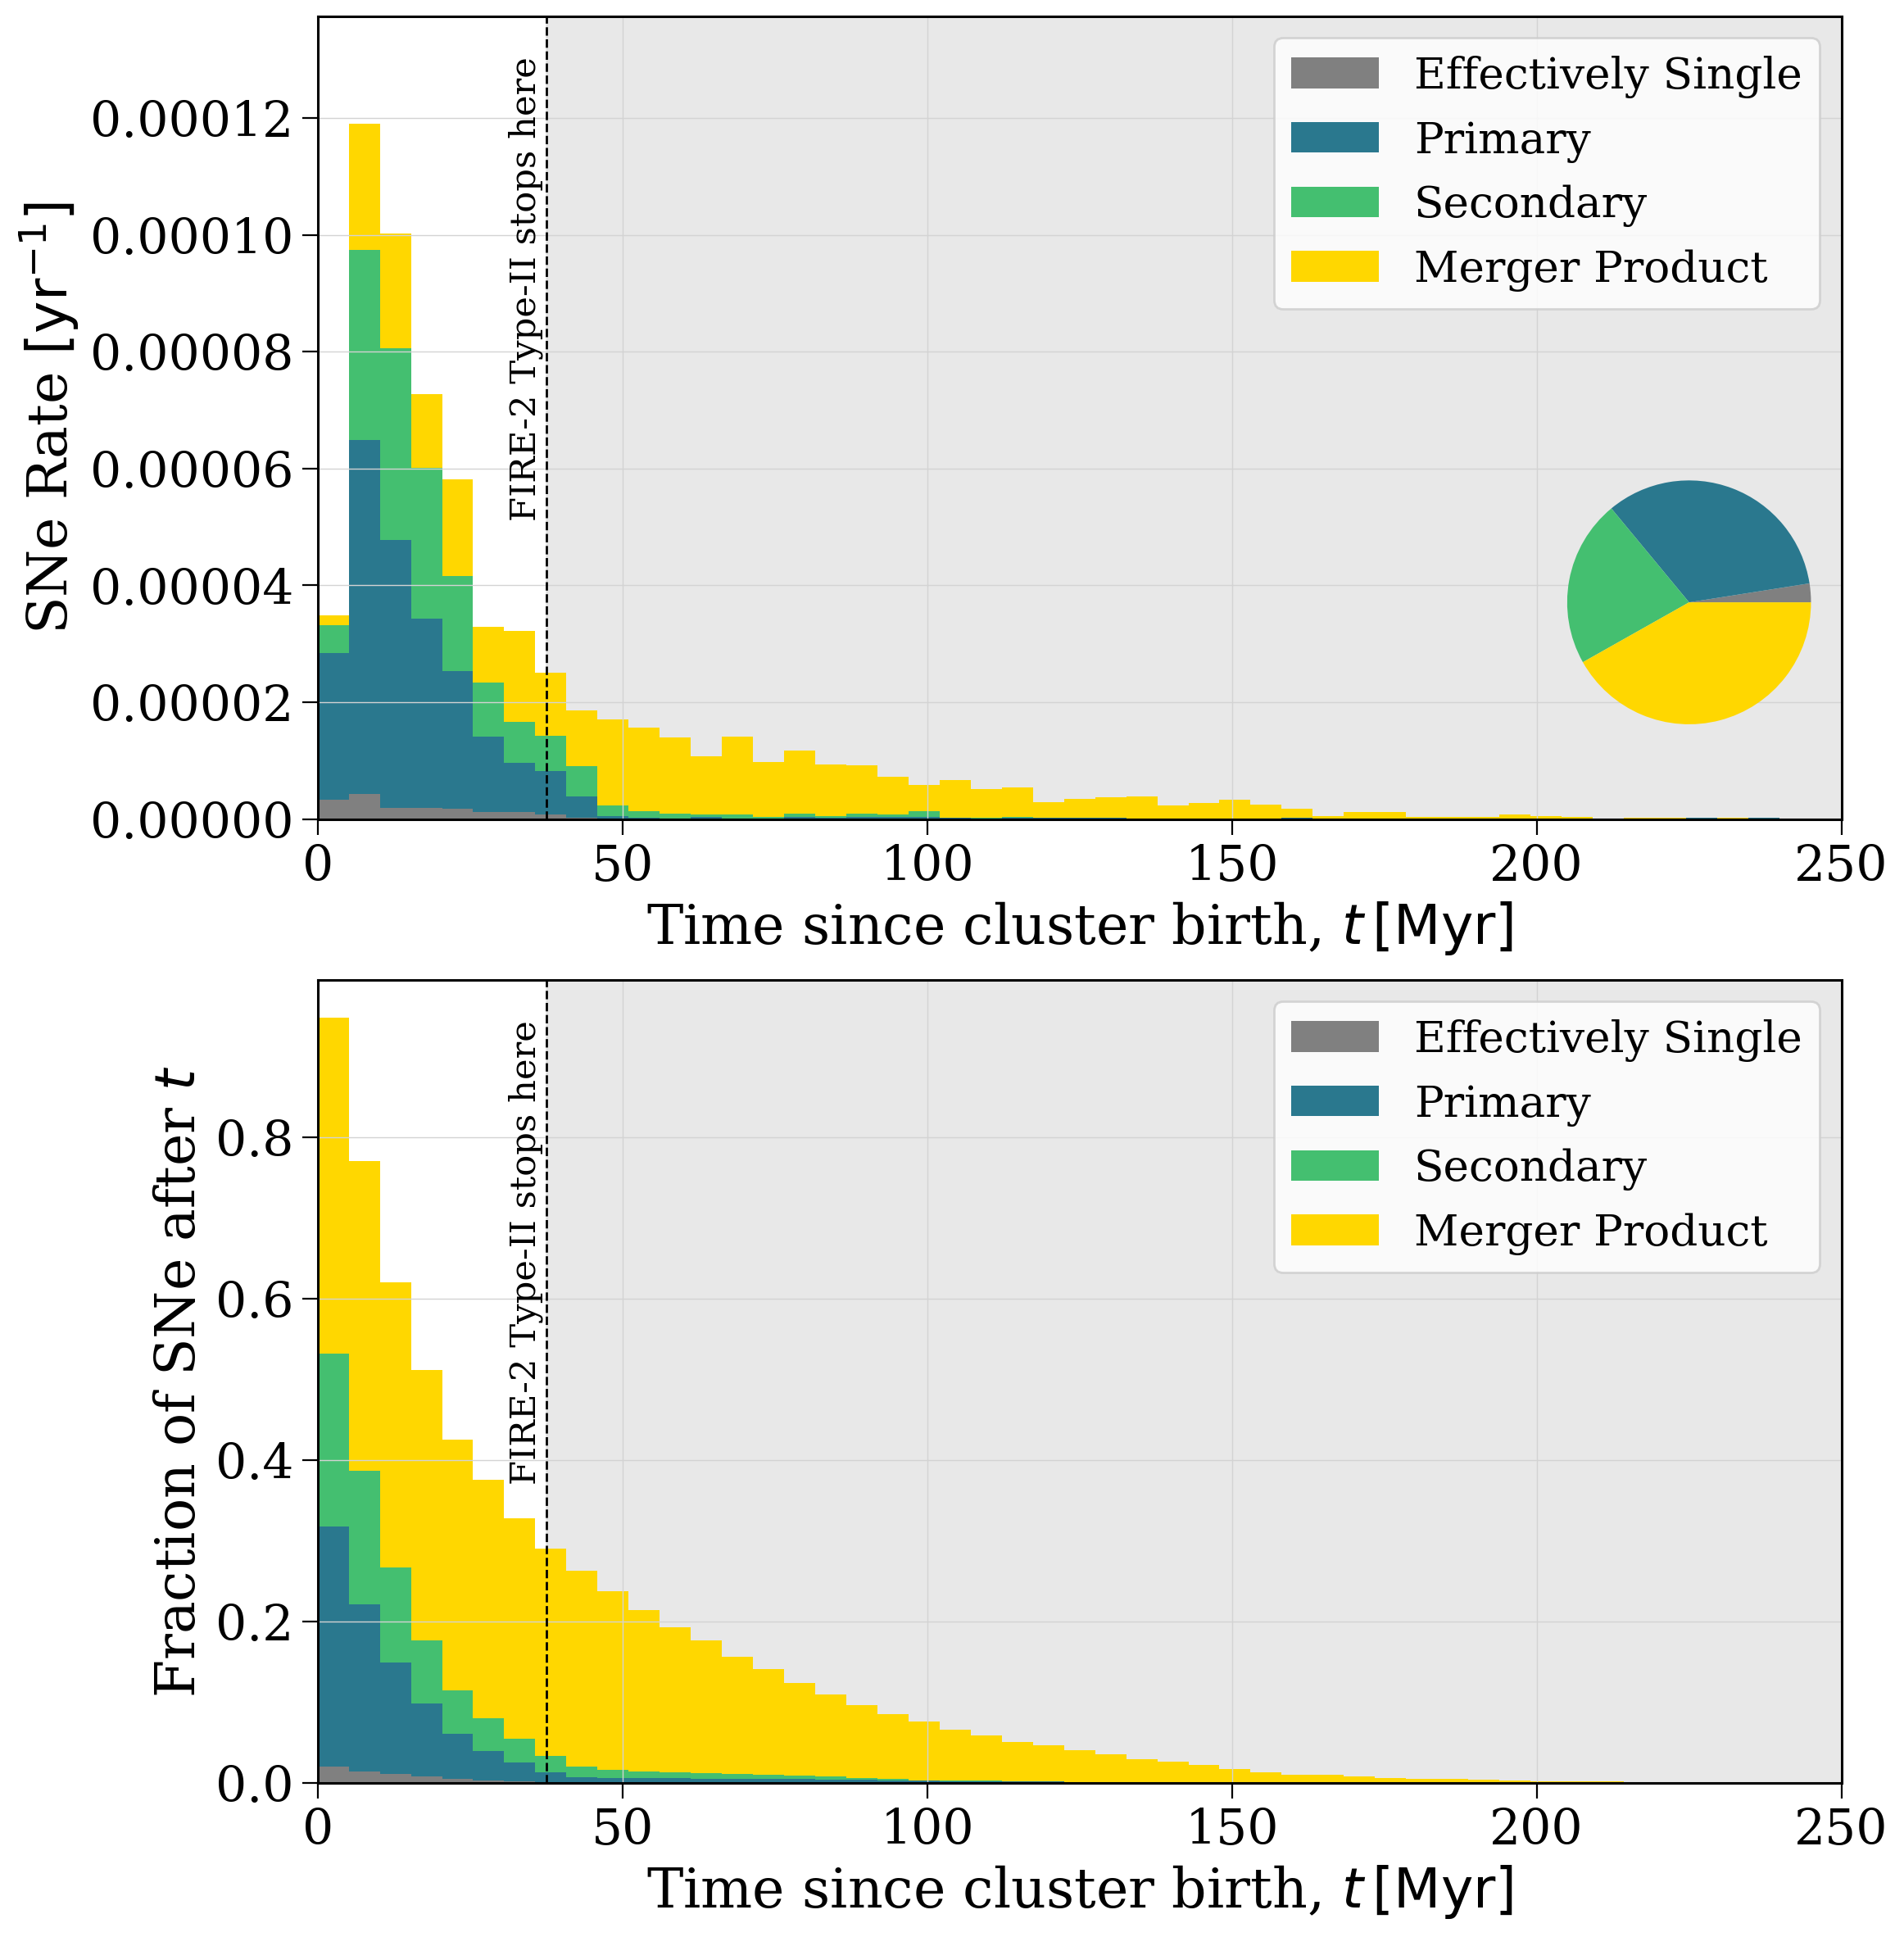

In [136]:
bottom_ylabel = {
    "distance": r"Fraction of SNe > $d$",
    "time": r"Fraction of SNe after $t$",
    "ejecta_mass": r"Fraction of ejecta mass > $d$"
}
    
xlabel = {
    "distance": "SN distance from parent cluster [pc]",
    "time": r"Time since cluster birth, $t \, [\rm Myr]$",
    "ejecta_mass": "SN distance from parent cluster [pc]",
}

top_ylabel = {
    "distance": "Number of SN",
    "time": r"SNe Rate $\rm [yr^{-1}]$",
    "ejecta_mass": r"Ejecta mass $[\rm M_\odot]$"
}

labels = ["Effectively Single", "Primary", "Secondary", "Merger Product"]
colours = ["grey", plt.cm.viridis(0.4), plt.cm.viridis(0.7), "gold"]


def weighted_median(values, weights):
    """https://stackoverflow.com/questions/20601872/numpy-or-scipy-to-calculate-weighted-median"""
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]


def sandpile(p, bins=np.geomspace(2e0, 3e3, 400),
             var="distance", comparison_pop=None,
             fig=None, axes=None, show=True):
    """Create a sandpile plot related to a population's supernovae"""
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    # set up bins and widths
    bin_centres = np.array([(bins[i] + bins[i + 1]) / 2. for i in range(len(bins) - 1)])
    widths = np.insert(bin_centres[1:] - bin_centres[:-1], -1, bin_centres[1] - bin_centres[0])

    # setup data and weights based on variable choice
    if var == "distance" or var == "ejecta_mass":
        data = [np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_singles],
                                p.secondary_sn_distances.to(u.pc).value[p.sn_2_singles])),
                 p.primary_sn_distances.to(u.pc).value[p.sn_1],
                 p.secondary_sn_distances.to(u.pc).value[p.sn_2],
                 np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_merger],
                                 p.secondary_sn_distances.to(u.pc).value[p.sn_2_merger]))]
        weights = [np.ones_like(d) for d in data]
    elif var == "time":
        sn_time_1 = p.bpp["tphys"][(p.bpp["evol_type"] == 15) & (~p.bpp["bin_num"].isin(p.duplicate_sn))]
        sn_time_2 = p.bpp["tphys"][(p.bpp["evol_type"] == 16) & (~p.bpp["bin_num"].isin(p.duplicate_sn))]
        data = [np.concatenate((sn_time_1[p.sn_1_singles], sn_time_2[p.sn_2_singles])),
                sn_time_1[p.sn_1],
                sn_time_2[p.sn_2],
                np.concatenate((sn_time_1[p.sn_1_merger], sn_time_2[p.sn_2_merger]))]
        weights = [np.ones_like(d) / (widths[0] * 1e6) for d in data]
        
    if var == "ejecta_mass":
        ejecta_mass_1 = p.bpp["mass_1"].diff(-1).fillna(0.0)[(p.bpp["evol_type"] == 15) & (~p.bpp["bin_num"].isin(p.duplicate_sn))]
        ejecta_mass_2 = p.bpp["mass_2"].diff(-1).fillna(0.0)[(p.bpp["evol_type"] == 16) & (~p.bpp["bin_num"].isin(p.duplicate_sn))]
        weights = [np.concatenate((ejecta_mass_1[p.sn_1_singles],
                                   ejecta_mass_2[p.sn_2_singles])),
                   ejecta_mass_1[p.sn_1].values,
                   ejecta_mass_2[p.sn_2].values,
                   np.concatenate((ejecta_mass_1[p.sn_1_merger],
                                   ejecta_mass_2[p.sn_2_merger]))]
        # return data, weights

    # set x-axis scale and labels, grid also
    for ax in axes:
        ax.set(xscale="log" if var != "time" else "linear",
               xlabel=xlabel[var])
        if var == "time":
            ax.set_xlim([bins[0], bins[-1]])
        ax.grid(linewidth=0.5, color="lightgrey")

    # start with the top panel
    ax = axes[0]

    # plot sandpile and set ylabel
    ax.hist(data, bins=bins, label=labels, stacked=True, color=colours, weights=weights);
    ax.set_ylabel(ylabel=top_ylabel[var])

    # give some extra room at the top
    ax.set_ylim(top=ax.get_ylim()[-1] * 1.1)
    
    if var in ["distance", "ejecta_mass"]:
        # if comparing to another population then plot the entire thing on top    
        if comparison_pop is not None:
            ax.hist(np.concatenate((comparison_pop.primary_sn_distances[~p.sn_truly_single],
                                    comparison_pop.secondary_sn_distances)).to(u.pc).value,
                    bins=bins, histtype="step", color="grey", lw=2)
        
        # add markers for the median and another axis on top for ease of reading
        for d, w, c in zip(data, weights, colours):
            ax.axvline(weighted_median(d, w), color=c, zorder=-1, lw=3)
        ax_top = ax.twiny()
        ax_top.set(xlim=ax.get_xlim(), xscale=ax.get_xscale(), xticklabels=[])
        
        # inset axis
        inset_lims = (500, 2000)
        inset_loc = [0.7, 0.5, 0.28, 0.48]
        inset_ax = ax.inset_axes(inset_loc)

        for d, w, l, c in zip(data, weights, labels, colours):
            inset_ax.hist(d, bins=np.linspace(*inset_lims, 50), weights=w, label=l, color=c, alpha=0.1);
            inset_ax.hist(d, bins=np.linspace(*inset_lims, 50), weights=w, label=l, color=c, histtype="step", lw=2);

        inset_ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(250))
        inset_ax.tick_params(axis='both', labelsize=0.5 * fs)
        inset_ax.set_xlim(inset_lims)
    
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()

        t = ax.transLimits.inverted()
        ax.plot([inset_lims[0], 10**t.transform((inset_loc[0], 0.0))[0]],
                [0, t.transform((0, inset_loc[1]))[1]], color='darkgrey', linestyle='dotted')
        ax.plot([inset_lims[1], 10**t.transform((inset_loc[0] + inset_loc[2], 0.0))[0]],
                [0, t.transform((0, inset_loc[1]))[1]], color='darkgrey', linestyle='dotted')

        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
    

    # now for the bottom panel
    ax = axes[1]
    
    # we only want weights if the variable is ejecta mass
    if var != "ejecta_mass":
        weights = [np.ones_like(d) / (widths[0] * 1e6) for d in data]

    # create a bunch of histograms
    hists = np.array([np.histogram(d, weights=w, bins=bins)[0].astype(float) for d, w in zip(data, weights)])
    bottom = np.zeros_like(hists[0])
    norm = np.sum(hists)

    # normalise them
    hists /= norm

    # plot each one on top of the next
    for hist, c, l in zip(hists, colours, labels):
        print(np.sum(hist))
        ax.bar(bin_centres, np.sum(hist) - np.cumsum(hist), color=c, bottom=bottom, width=widths, label=l)
        bottom += np.sum(hist) - np.cumsum(hist)
    ax.legend(loc="upper right", fontsize=0.8*fs)
    ax.set_ylabel(bottom_ylabel[var])
    
    # inset pie chart
    inset_loc = [0.8, 0.02, 0.2, 0.5] if var == "time" else [0.01, 0.57, 0.2, 0.5]
    pie_ax = axes[0].inset_axes(inset_loc)
    pie_ax.pie([np.sum(hist) for hist in hists], colors=colours)
    
    # add another non-normalised axis on the right for eject mass
    if var == "ejecta_mass":
        ax_right = ax.twinx()
        ax_right.set_ylim(top=ax.get_ylim()[1] * norm)
        ax_right.set_ylabel(r"Ejecta mass > $d \,\, [\rm M_\odot$]")

    # add a vertical line for the FIRE-2 Type-II SN stopping point and shade an area for time
    if var == "time":
        for ax in axes:
            ax.axvline(37.53, linestyle="--", color="black", lw=1)
            t = ax.transLimits.inverted()
            ax.annotate("FIRE-2 Type-II stops here", xy=(37, t.transform((0.5, 0.95))[1]),
                        rotation=90, color="black", va="top", ha="right", fontsize=0.65*fs)
            ax.axvspan(37.53, bins[-1] * 1.2, color="lightgrey", zorder=-10, alpha=0.5)
            ax.legend(fontsize=0.8 * fs)

    if show:
        plt.show()
    return fig, axes

fig, axes = sandpile(p, bins=np.geomspace(2e0, 3e3, 50), comparison_pop=p)
fig, axes = sandpile(p, bins=np.geomspace(2e0, 3e3, 50), var="ejecta_mass")
fig, axes = sandpile(p, bins=np.linspace(0, 250, 50), comparison_pop=p, var="time")

0.03004029970864721
0.25317328683724405
0.21902086427627465
0.4977655491778341


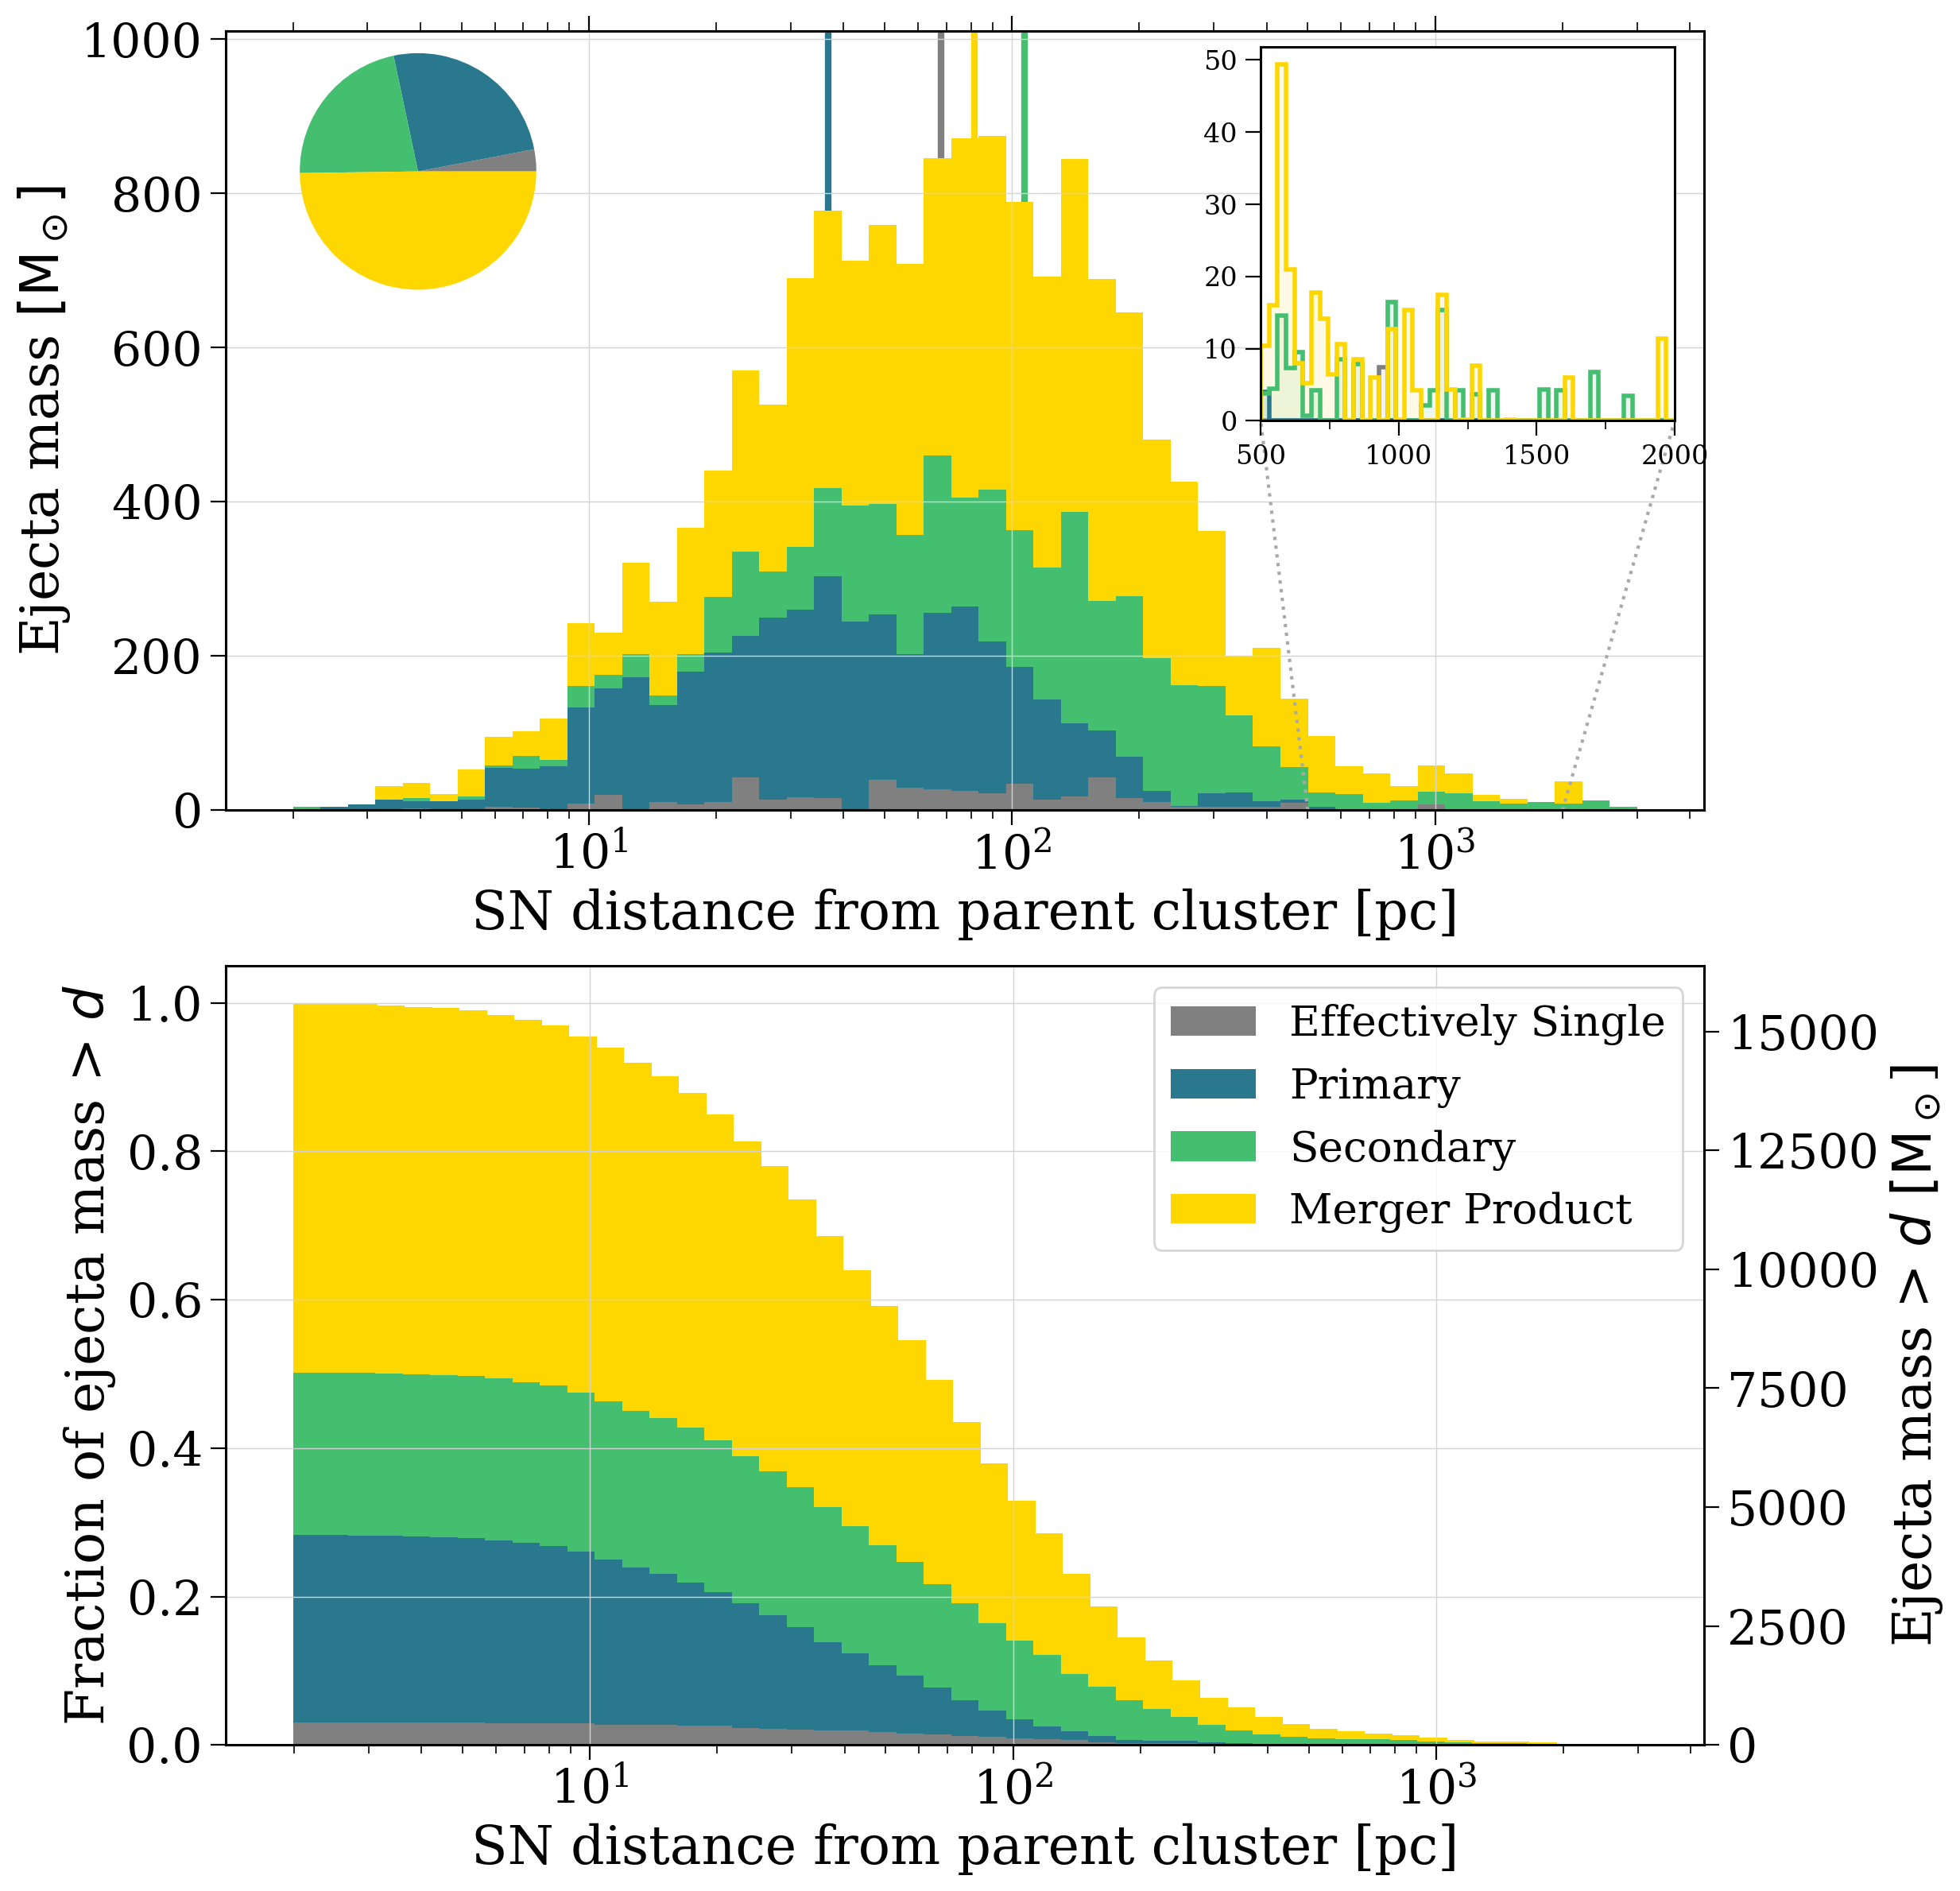

In [134]:
data, weights = sandpile(p, bins=np.geomspace(2e0, 3e3, 50), var="ejecta_mass")

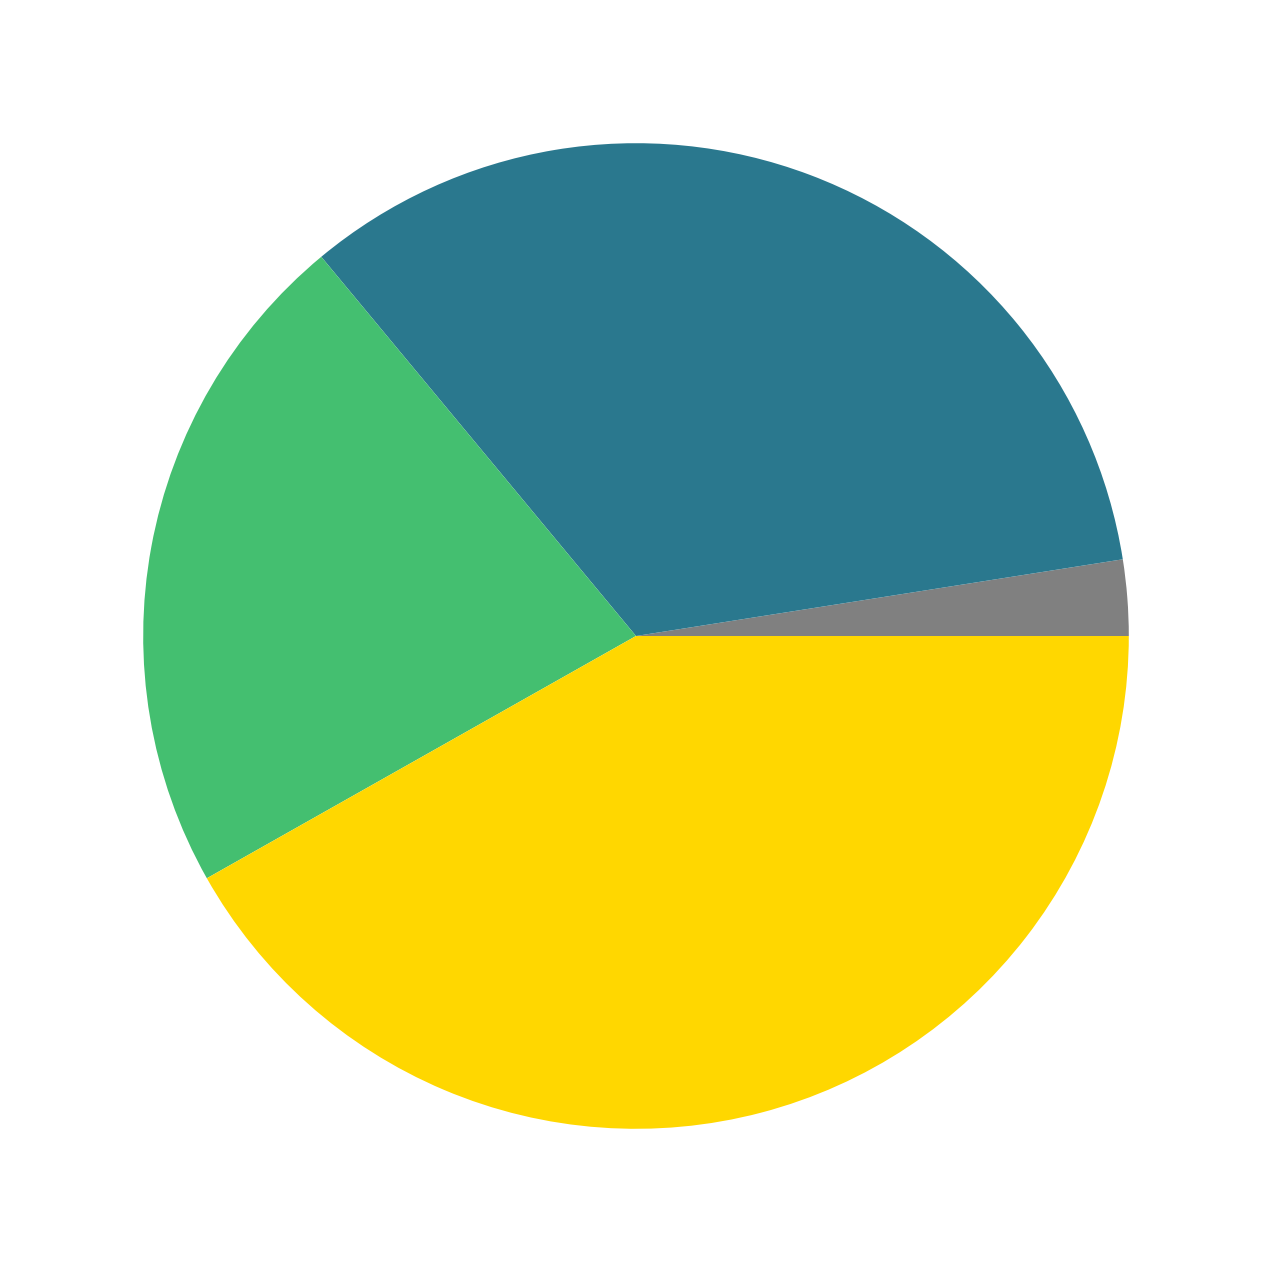

In [108]:
plt.pie([0.024875621890547442, 0.3353819139596137, 0.2215393620134623, 0.4182031021363767],
        colors=colours);